# Transforms

> Data transformations and augmentations for 2D and 3D BioImages

In [ ]:
#| default_exp transforms

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
from fastai.vision.all import *
from fastai.data.all import *
from monai.transforms import SpatialCrop, Flip, Rotate90, Spacing, Resize as mResize
from numpy import percentile, isscalar, float32 as np_float32

from bioMONAI.data import BioImageBase, BioImageStack

## Size & Sampling

In [ ]:
#| export
class Resample(Transform):
    """
    A subclass of Spacing that handles image resampling based on specified sampling factors or voxel dimensions.
    
    The `Resample` class inherits from `Spacing` and provides a flexible way to adjust the spacing (voxel size) of images by specifying either a sampling factor or explicitly providing new voxel dimensions.
    
    Args:
        sampling (int, optional): Sampling factor for isotropic resampling. Default is 1, indicating no change in resolution.
        **kwargs: Additional keyword arguments that can include 'pixdim' to specify custom voxel dimensions.
        
    Attributes:
        pixdim (list or tuple): The voxel dimensions of the image after resampling. If not provided during initialization, this will be determined based on the sampling factor and original image properties.
    
    
    """
    
    def __init__(self, sampling, **kwargs):
        """
        Initializes the Resample class instance.
        
        Args:
            sampling (int, optional): Sampling factor for isotropic resampling. Default is 1.
            **kwargs: Additional keyword arguments that can include 'pixdim' to specify custom voxel dimensions.
            
        If 'pixdim' is provided in kwargs, it will be used directly; otherwise, the sampling factor will determine the new voxel dimensions.
        
        The Spacing class from which Resample inherits is initialized with either the provided pixdim or calculated based on the sampling factor and original image properties.
        """
        if 'pixdim' in kwargs:
            self.spacing = Spacing(**kwargs)
        else:
            self.spacing = Spacing(sampling, **kwargs)
                    
    def encodes(self, img:BioImageBase):
        bioimagetype = type(img)
        return bioimagetype(self.spacing(img))


In [ ]:
from bioMONAI.core import cells3d, img2Tensor
from bioMONAI.visualize import visualize_slices

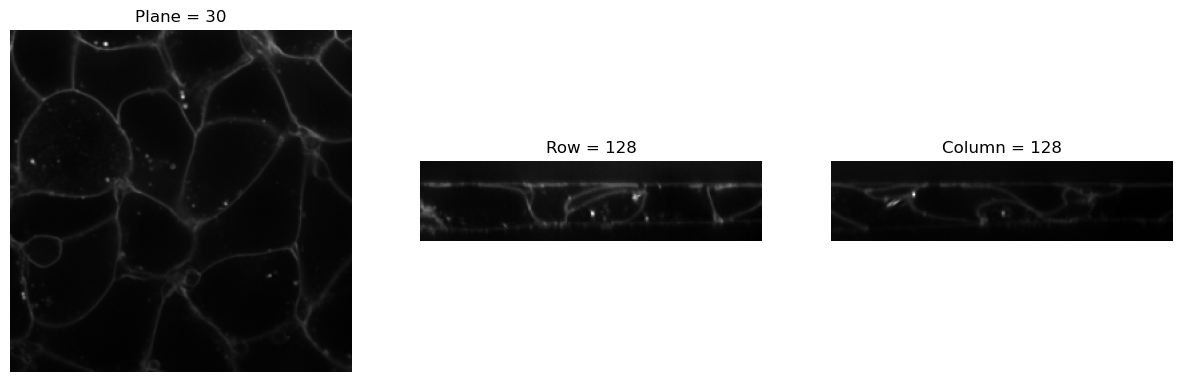

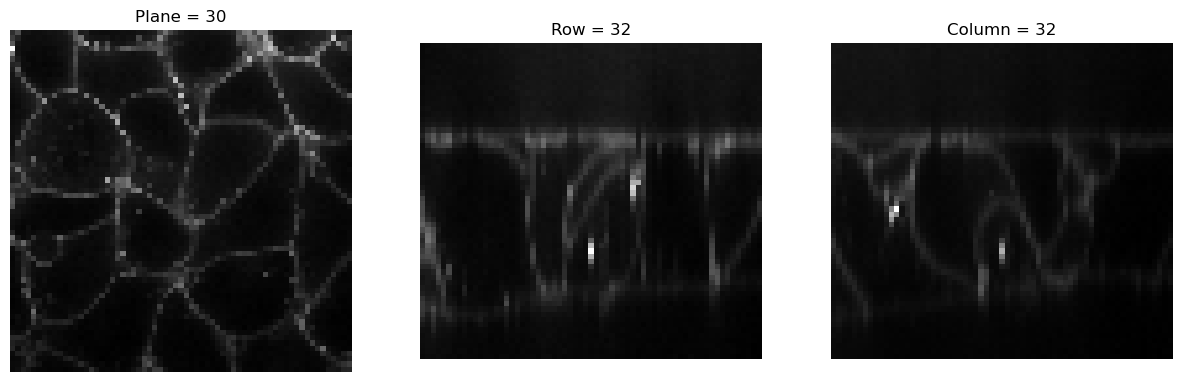

In [ ]:
img = BioImageStack(img2Tensor(cells3d()[:,0]))
visualize_slices(img, showlines=False)

img2 = Resample(4)(img)
visualize_slices(img2, showlines=False)

In [ ]:
#| export
class Resize(Transform):
    """
    A subclass of Reshape that handles image resizing based on specified target dimensions.

    The `Resize` class inherits from `Reshape` and provides a flexible way to adjust the size of images by specifying either a target size or scaling factors.

    Args:
        size (int, tuple, or list, optional): Target dimensions for resizing (height, width). If its length is smaller than the spatial dimensions of the image, values will be repeated to match. If an int is provided, it will be broadcast to all spatial dimensions. Default is None, which indicates no resizing.
        **kwargs: Additional keyword arguments that can include scaling factors or interpolation methods.

    Attributes:
        target_size (tuple or list): The target dimensions of the image after resizing. If not provided during initialization, this will be determined based on the original image properties and optional scaling factors.
    """

    def __init__(self, size=None, **kwargs):
        """
        Initializes the Resize class instance.

        Args:
            size (int, tuple, or list, optional): Target dimensions for resizing (height, width). If its length is smaller than the spatial dimensions, values will be repeated. If an int is provided, it will be broadcast to all spatial dimensions.
            **kwargs: Additional keyword arguments that can include scaling factors or interpolation methods.

        If 'size' is provided, it will be used directly to resize the image; otherwise, scaling factors or default values will determine the new dimensions.

        The Reshape class from which Resize inherits is initialized with the provided size or calculated dimensions.
        """
        self.size = size
        self.kwargs = kwargs

    def _expand_size(self, size, spatial_dims):
        """
        Expands the size to match the spatial dimensions by repeating values if necessary or broadcasting if size is an int.

        Args:
            size (int, list, or tuple): The target size provided.
            spatial_dims (int): Number of spatial dimensions in the image.

        Returns:
            list: Expanded size matching the spatial dimensions.
        """
        if size is None:
            return None
        if isinstance(size, int):
            return [size] * spatial_dims
        size = list(size)
        while len(size) < spatial_dims:
            size.extend(size)
        return size[:spatial_dims]

    def encodes(self, img: BioImageBase):
        """
        Resizes the given image to the target dimensions.

        Args:
            img (BioImageBase): The input image to resize.

        Returns:
            BioImageBase: The resized image.
        """
        bioimagetype = type(img)
        spatial_dims = len(img.shape) - 1  # Assuming the first dimension is channels or similar.
        expanded_size = self._expand_size(self.size, spatial_dims)
        reshape_instance = mResize(spatial_size=expanded_size, **self.kwargs)
        return bioimagetype(reshape_instance(img))


torch.Size([60, 256, 256])


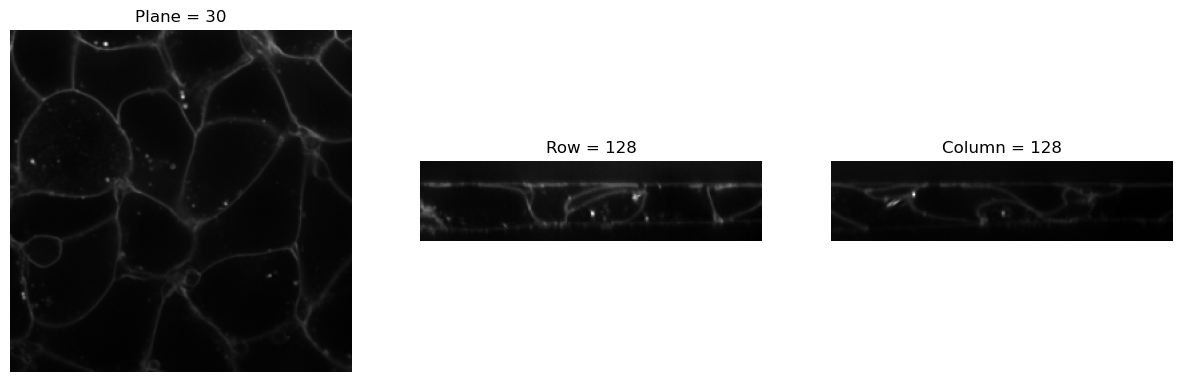

torch.Size([60, 50, 50])


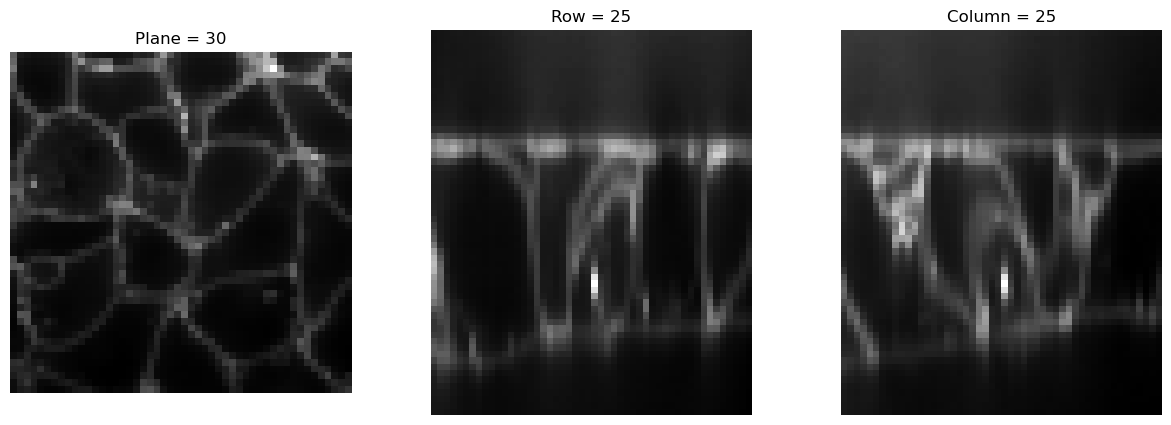

In [ ]:
print(img.size())
visualize_slices(img, showlines=False)

img2 = Resize(50)(img)
print(img2.size())
visualize_slices(img2, showlines=False)

## Noise

In [ ]:
#| export
class RandCameraNoise(RandTransform):
    """
    Simulates camera noise by adding Poisson shot noise, dark current noise, and optionally CMOS fixed pattern noise.
    
    Returns:
        numpy.ndarray: The noisy image as a NumPy array with dimensions of input_image.
    """
    def __init__(self, p:float=1., # Probability of applying Transform
                 damp=1e-2, # Dampening factor to prevent saturation when adding noise
                 qe=0.7, # Quantum efficiency of the camera (0 to 1).
                 gain=2, # Camera gain factor. If an array, it should be broadcastable with input_image shape. 
                 offset=100, # Camera offset in ADU. If an array, it should be broadcastable with input_image shape. 
                 exp_time=0.1, # Exposure time in seconds. 
                 dark_current=0.6, # Dark current per pixel in electrons/second. 
                 readout=1.5, # Readout noise standard deviation in electrons.
                 bitdepth=16, # Bit depth of the camera output.
                 seed=42, # Seed for random number generator for reproducibility. 
                 simulation=False, # If True, assumes input_image is already in units of photons and does not convert from electrons.
                 camera='cmos', # Specifies the type of camera ('cmos' or any other). Used to add CMOS fixed pattern noise if 'cmos' is specified. 
                 gain_variance=.1, # Variance for the gain noise in CMOS cameras. Only applicable if camera type is 'cmos'. 
                 offset_variance=5 # Variance for the offset noise in CMOS cameras. Only applicable if camera type is 'cmos'.
                 ):
        store_attr()
        self.rs = np.random.RandomState(seed=seed)
        
    def encodes(self, 
               input_image: BioImageBase, # The original image 
               ):
        rs = self.rs
        bioimagetype = type(input_image)
        # If the input image is between 0.0 and 1.0 and bitdepth is specified, rescale it to fit within the bit depth range (0 to 2^bitdepth - 1)
        max_adu = float(2**self.bitdepth - 1)  # Calculate maximum possible ADU value for the given bit depth
        if input_image.min() >= 0.0 and input_image.max() <= 1.0:
            input_image = (input_image * max_adu).astype(np.uint16 if self.bitdepth > 8 else np.uint8)
            
        # If simulation mode, assume input_image is already in units of photons
        if not self.simulation:
            input_photons = input_image / self.gain / self.qe * self.damp
        else:
            input_photons = input_image
        
        # Add Poisson shot noise to the input image in terms of photons or directly as electrons
        photons = rs.poisson(input_photons, size=input_photons.shape)
        electrons = self.qe * photons  # Convert photons to electrons using quantum efficiency (qe)
        
        # Add dark current noise
        dark_noise = rs.poisson(self.dark_current * self.exp_time, size=electrons.shape)
        electrons += dark_noise  # Convert dark current from rate to number of events
        
        # Add readout noise
        read_noise = rs.normal(scale=self.readout**2, size=electrons.shape)*self.bitdepth/16
        electrons += read_noise  # Adding normal distributed noise based on readout standard deviation
        
        gain = self.gain
        offset = self.offset
        
        if self.camera == 'cmos':
            # Add gain noise in CMOS cameras
            gain_noise = rs.normal(scale=self.gain_variance, size=electrons.shape)
            # Add offset noise and fixed pattern noise in CMOS cameras
            offset_noise = rs.normal(scale=self.offset_variance, size=electrons.shape) + rs.normal(scale=self.offset_variance, size=electrons.shape[0])
            gain += gain_noise # Adjusting the gain by adding normally distributed noise
            offset += offset_noise  # Adding offset noise and fixed pattern noise
        
        adu = (electrons * gain) + offset  # Convert electrons to ADU, then add offset
        adu[adu > max_adu] = max_adu  # Clip values above full scale to avoid overflow
        
        return bioimagetype(adu)


In [ ]:
from bioMONAI.visualize import plot_image


In [ ]:
img3 = img[30]

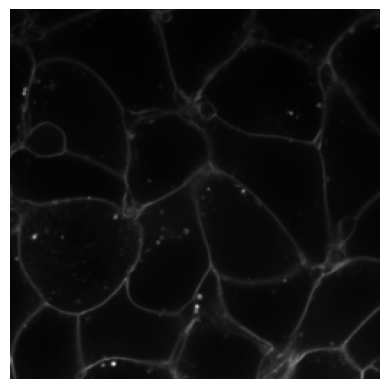

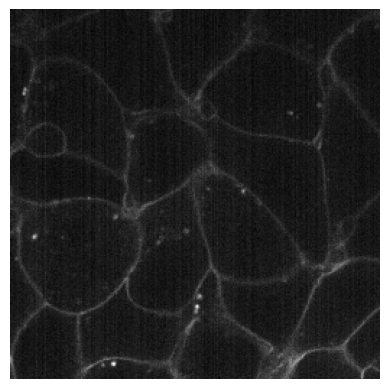

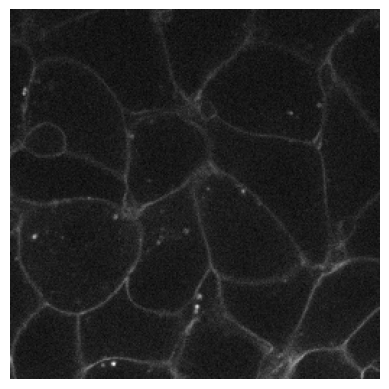

In [ ]:
plot_image(img3)
plot_image(RandCameraNoise(camera = 'cmos').encodes(img3))
plot_image(RandCameraNoise(camera = 'ccd', readout=2).encodes(img3))

## Normalization

In [ ]:
#| export
def _scale_intensity_range(x, mi, ma, eps=1e-20, dtype=np_float32):
    if dtype is not None:
        x = x.astype(dtype, copy=False)
        mi = dtype(mi) if isscalar(mi) else mi.astype(dtype, copy=False)
        ma = dtype(ma) if isscalar(ma) else ma.astype(dtype, copy=False)
        eps = dtype(eps)
        x = (x - mi) / (ma - mi + eps)
    return x

In [ ]:
#| export
class ScaleIntensity(Transform):
    """Image normalization."""
    def __init__(x, min=0.0, max=1.0, axis=None, eps=1e-20, dtype=np_float32):
        store_attr()

    def encodes(self, x: BioImageBase):
        bioimagetype = type(x)
        y = _scale_intensity_range(x, x.min(), x.max(), eps=self.eps, dtype=self.dtype)
        y *= self.max
        y += self.min
        return bioimagetype(y)

In [ ]:
#| export
class ScaleIntensityPercentiles(Transform):
    """Percentile-based image normalization."""
    def __init__(x, pmin=3, pmax=99.8, axis=None, clip=True, b_min=0.0, b_max=1.0, eps=1e-20, dtype=np_float32):
        store_attr()

    def encodes(self, x: BioImageBase):
        bioimagetype = type(x)
        mi = percentile(x, self.pmin, axis=self.axis, keepdims=True)
        ma = percentile(x, self.pmax, axis=self.axis, keepdims=True)
        if self.clip:
            return bioimagetype(np.clip(_scale_intensity_range(x, mi, ma, eps=self.eps, dtype=self.dtype), self.b_min, self.b_max))
        return bioimagetype(_scale_intensity_range(x, mi, ma, eps=self.eps, dtype=self.dtype))


In [ ]:
#| export
class ScaleIntensityVariance(Transform):
    """
    Scales the intensity variance of an ND image to a target value.
    
    Args:
        target_variance (float): The desired variance for the scaled intensities.
        ndim (int): Number of spatial dimensions in the image. Default is 2 for 2D images.
    """
    def __init__(self, ndim=2):
        store_attr()
        
    def encodes(self, x: BioImageBase):
        bioimagetype = type(x)
        # Calculate the current variance of the image intensities
        mean, variance = torch.mean(x), torch.var(x)
        
        # Calculate the scaling factor based on the ratio of target to current variance
        scale_factor = (1.0 / variance).sqrt()
        
        # Apply the scaling factor to each channel in the image
        if x.ndim == self.ndim + 1:  # Check if it's a multi-channel image (e.g., RGB)
            for i in range(x.shape[0]):
                x[i] = (x[i] - mean) * scale_factor
        else:
            x = (x - mean) * scale_factor
        
        return bioimagetype(x)


In [ ]:

# Example usage with a random tensor of shape (1, 3, 256, 256)
rand_tensor = BioImageBase(torch.rand(1, 3, 256, 256))

transform = ScaleIntensityVariance(ndim=4)

# Apply the transform to the tensor
scaled_tensor = transform(rand_tensor)

print('Original Tensor Variance:', rand_tensor.var().item())
print('Scaled Tensor Variance:', scaled_tensor.var().item())


Original Tensor Variance: 0.08341076225042343
Scaled Tensor Variance: 1.0


## Data Augmentation

In [ ]:
#| export
def _process_sz(size, ndim=3):
    if isinstance(size,int): 
        size=(size,)*ndim
    return fastuple(size)

def _get_sz(x):
    if isinstance(x, tuple): x = x[0]
    if not isinstance(x, Tensor): return fastuple(x.size)
    return fastuple(getattr(x, 'img_size', getattr(x, 'sz', (x.shape[1:])))) # maybe it should swap x and y axes 

In [ ]:
#| hide
# Define a random tensor
orig_size = (10, 8)
rand_tensor = torch.rand(3, *orig_size)  # Random tensor with shape (3, 10, 8)

test_eq((3,)*3,_process_sz(3,ndim=3))
test_eq(orig_size,_get_sz((rand_tensor, rand_tensor)))

In [ ]:
#| export

class RandCrop2D(RandTransform):
    "Randomly crop an image to `size`"
    split_idx,order = None,1
    def __init__(self, 
        size:int|tuple, # Size to crop to, duplicated if one value is specified
        lazy = False,   # a flag to indicate whether this transform should execute lazily or not. Defaults to False
        **kwargs
    ):
        size = _process_sz(size, ndim=2)
        store_attr()
        super().__init__(**kwargs)

    def before_call(self, 
        b, 
        split_idx:int # Index of the train/valid dataset
    ):
        "Randomly positioning crop if train dataset else center crop"
        self.orig_sz = _get_sz(b)
        if split_idx: self.ctr = (self.orig_sz)//2
        else:
            wd = self.orig_sz[0] - self.size[0]
            hd = self.orig_sz[1] - self.size[1]
            w_rand = (wd, -1) if wd < 0 else (0, wd)
            h_rand = (hd, -1) if hd < 0 else (0, hd)
            self.ctr = fastuple(random.randint(*w_rand)+self.size[0]//2, random.randint(*h_rand)+self.size[1]//2)

    def encodes(self, x: BioImageBase):
        bioimagetype = type(x)
        return bioimagetype(SpatialCrop(roi_center=self.ctr, roi_size=self.size, lazy=self.lazy)(x))

In [ ]:
#| export

class RandCropND(RandTransform):
    """
    Randomly crops an ND image to a specified size.

    This transform randomly crops an ND image to a specified size during training and performs
    a center crop during validation. It supports both 2D and 3D images and videos, assuming
    the first dimension is the batch dimension.

    Args:
        size (int or tuple): The size to crop the image to. this can have any number of dimensions. 
                             If a single value is provided, it will be duplicated for each spatial 
                             dimension, up to a maximum of 3 dimensions.
        **kwargs: Additional keyword arguments to be passed to the parent class.
    """

    split_idx,order = None,1
        
    def __init__(self, size: int | tuple, # Size to crop to, duplicated if one value is specified
                 lazy = False,            # a flag to indicate whether this transform should execute lazily or not. Defaults to False
                 **kwargs):
        size = _process_sz(size)
        store_attr()
        super().__init__(**kwargs)

    def before_call(self, b, split_idx: int):
        "Randomly position crop if train dataset else center crop"
        self.orig_sz = _get_sz(b)
        if split_idx:
            self.tl = tuple((osz - sz) // 2 for osz, sz in zip(self.orig_sz, self.size))
            self.br = tuple((osz + sz) // 2 for osz, sz in zip(self.orig_sz, self.size))
        else:
            tl = [] # top-left corner
            br = [] # bottom-right corner
            # Calculate top-left and bottom-right corner coordinates for random crop
            for osz, sz in zip(self.orig_sz, self.size):
                w_dif = osz - sz
                if w_dif < 0:
                    w_rand = (0, 0) # No random cropping if input size is smaller than crop size
                    sz = osz # Adjust crop size to match input size
                else:
                    w_rand = (0, w_dif)
                rnd = random.randint(*w_rand)
                tl.append(rnd)
                br.append(rnd + sz)
            self.tl = fastuple(*tl)
            self.br = fastuple(*br)

    def encodes(self, x:BioImageBase):
        "Apply spatial crop transformation to the input image."
        bioimagetype = type(x)
        return bioimagetype(SpatialCrop(roi_start=self.tl, roi_end=self.br, lazy=self.lazy)(x))
    

In [ ]:
# Define a random tensor
orig_size = (65, 65)
rand_tensor = BioImageBase(torch.rand(8, *orig_size))

for i in range(100):
    test_eq((8,64,64),RandCropND((64,64))(rand_tensor).shape)

In [ ]:
#| export

class RandFlip(RandTransform):
    """
    Randomly flips an ND image over a specified axis.

    """

    split_idx,order = None,1
        
    def __init__(self, 
                 prob = 0.1,            # Probability of flipping
                 spatial_axis = None,   # Spatial axes along which to flip over. Default is None. The default axis=None will flip over all of the axes of the input array. 
                                        # If axis is negative it counts from the last to the first axis. If axis is a tuple of ints, flipping is performed on all of the axes specified in the tuple.
                 ndim = 2,
                 lazy = False,          # Flag to indicate whether this transform should execute lazily or not. Defaults to False
                 **kwargs):
        store_attr()
        super().__init__(**kwargs)

    def before_call(self, b, split_idx: int):
        if split_idx:
            self.flip = 0
        else:
            self.flip = np.random.choice([0, 1], p=[1-self.prob, self.prob])
        if self.spatial_axis is None:
            self.spatial_axis = np.random.choice(np.arange(self.ndim), size=np.random.randint(1, self.ndim+1), replace=False, p=None)
            
    def encodes(self, x:BioImageBase):
        bioimagetype = type(x)
        if self.flip:
            return bioimagetype(Flip(spatial_axis=self.spatial_axis, lazy=self.lazy)(x))
        else:
            return bioimagetype(x)

In [ ]:
# Define a random tensor
orig_size = (1,4,4)
rand_tensor = BioImageBase(torch.rand(*orig_size))

print('orig tensor: ', rand_tensor, '\n')

for i in range(3):
    print(RandFlip(prob=.75, spatial_axis=None)(rand_tensor))

orig tensor:  metatensor([[[0.8943, 0.3943, 0.2556, 0.8066],
         [0.5016, 0.6177, 0.8749, 0.1229],
         [0.9610, 0.1088, 0.5785, 0.6857],
         [0.5776, 0.7028, 0.5421, 0.3654]]]) 

metatensor([[[0.8066, 0.2556, 0.3943, 0.8943],
         [0.1229, 0.8749, 0.6177, 0.5016],
         [0.6857, 0.5785, 0.1088, 0.9610],
         [0.3654, 0.5421, 0.7028, 0.5776]]])
metatensor([[[0.8943, 0.3943, 0.2556, 0.8066],
         [0.5016, 0.6177, 0.8749, 0.1229],
         [0.9610, 0.1088, 0.5785, 0.6857],
         [0.5776, 0.7028, 0.5421, 0.3654]]])
metatensor([[[0.8066, 0.2556, 0.3943, 0.8943],
         [0.1229, 0.8749, 0.6177, 0.5016],
         [0.6857, 0.5785, 0.1088, 0.9610],
         [0.3654, 0.5421, 0.7028, 0.5776]]])


In [ ]:
#| export
class RandRot90(RandTransform):
    """
    Randomly rotate an ND image by 90 degrees in the plane specified by axes.

    """

    split_idx,order = None,1
        
    def __init__(self, 
                 prob = 0.1,            # Probability of rotating
                 max_k = 3,             # Max number of times to rotate by 90 degrees
                 spatial_axes = (0, 1),   # Spatial axes along which to rotate. Default: (0, 1), this is the first two axis in spatial dimensions.
                 ndim = 2,
                 lazy = False,          # Flag to indicate whether this transform should execute lazily or not. Defaults to False
                 **kwargs):
        store_attr()
        super().__init__(**kwargs)

    def before_call(self, b, split_idx: int):
        if split_idx:
            self.rot90 = 0
        else:
            self.rot90 = np.random.choice([0, 1], p=[1-self.prob, self.prob])
            self.k = 1 + np.random.randint(self.max_k)
        # if self.spatial_axes is None:
        #     self.spatial_axes = np.random.choice(np.arange(self.ndim), size=np.random.randint(1, self.ndim+1), replace=False, p=None)
            
    def encodes(self, x:BioImageBase):
        bioimagetype = type(x)
        if self.rot90:
            return bioimagetype(Rotate90(k=self.k, spatial_axes=self.spatial_axes, lazy=self.lazy)(x))
        else:
            return bioimagetype(x)

In [ ]:
# Define a random tensor
orig_size = (1,4,4)
rand_tensor = BioImageBase(torch.rand(*orig_size))

print('orig tensor: ', rand_tensor, '\n')

for i in range(3):
    print(RandRot90(prob=.75)(rand_tensor))

orig tensor:  metatensor([[[0.3961, 0.2351, 0.4363, 0.3366],
         [0.9416, 0.8529, 0.8646, 0.0091],
         [0.5012, 0.9804, 0.8109, 0.1094],
         [0.9639, 0.5107, 0.4666, 0.8632]]]) 

metatensor([[[0.3961, 0.2351, 0.4363, 0.3366],
         [0.9416, 0.8529, 0.8646, 0.0091],
         [0.5012, 0.9804, 0.8109, 0.1094],
         [0.9639, 0.5107, 0.4666, 0.8632]]])
metatensor([[[0.9639, 0.5012, 0.9416, 0.3961],
         [0.5107, 0.9804, 0.8529, 0.2351],
         [0.4666, 0.8109, 0.8646, 0.4363],
         [0.8632, 0.1094, 0.0091, 0.3366]]])
metatensor([[[0.8632, 0.4666, 0.5107, 0.9639],
         [0.1094, 0.8109, 0.9804, 0.5012],
         [0.0091, 0.8646, 0.8529, 0.9416],
         [0.3366, 0.4363, 0.2351, 0.3961]]])


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()